# Deep Learning

Deep Learning ist selbst eine Unterkategorie vom Machine Learning. 

Großer Unterschied:
- Wir legen keine Features/Variablen fest
- Klassisches ML benötigt viel Vorarbeit
    - Welche Variablen wollen wir extrahieren/messen?
    - Wie können wir sie (automatisch?) entnehmen
    - Oft sind Domänenexperten (bspw. Arzt für medizinische Modelle) notwendig
    - Heißt meistens teuer + limitiert durch die Auswahl an Features
- Deep Learning arbeitet mit der Annahme, dass das Modell komplex genug ist selber Zusammenhänge in den Daten zu finden
- Potentiell auch solche, an die man niemals denken würde

Bringt aber auch einen großen Nachteil mit sich mit:
- Durch die Komplexität sind die Modelle sogenannte _Black-Boxes_
- Heißt es ist sehr schwierig herauszufinden _wieso_ das Modell zu seiner Entscheidung kam

## Deep Learning mit Python

In Python gibt es zwei populäre Deep Learning Libraries.

### Tensorflow

- **Entwickler**: Google Brain 
- `tf.keras` bietet eine High-Level API an
    - Viele Vorimplementierte Quality-of-Life Funktionalitäten
    - Low-Level Zugriff ist recht schwierig
- Vorteil: einfache Handhabung
- Nachteil: schwierigeres Debugging + Manipulation von Funktionalitäten

### PyTorch

- **Entwickler**: Facebook's AI Reserarch Lab (FAIR) - Jetzt Pytorch Foundation
- Guter Low-Level Zugriff
- Etwas komplexer zu erlernen aber finde ich persönlich mächtiger
- Immer stärker verbreitet, insbesondere in der Wissenschaft

![](_img/04_tensorflow_vs_pytorch.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

## Datensatz Pipeline

Wir müssen die Daten etwas aufwendigerer vorbereiten als letztes mal damit sie gut mit dem Netzwerk funktionieren und unsere Grafikkarte nicht überfordern.

Wir können auf die Programmierschnittstelle für NVIDIA Grafikkarten zugreifen um effizienter zu trainieren.

Hier deklarieren wir ob wir auf der Grafikkarte arbeiten möchten (sofern verfügbar) oder auf dem Prozessor.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Laden der Trainings und Testdatensätze

PyTorch hat ähnlich wie `sklearn` Funktionen zum einfachen herunterladen bekannter Datensätze.

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          download=True)

### Inspektion der Daten

Lasst uns die Daten anschauen!

Mit `train_dataset[i]` können wir uns das `i`-te Element des Datensatzes anschauen.

Jedes Element beinhaltet:
- Das Bild der handgeschriebenen Zahl (28x28 pixel)
- Die jeweilige Klasse (`[0,1,2,3,4,5,6,7,8,9]`)

In [4]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
image, label = train_dataset[0]
image

In [6]:
label

5

### Aufbau eines Neuronalen Netzwerkes

![](_img/04_neural_network_structure.png)

Einfache Neuronale Netzwerke haben einen Schichtaufbau wobei jedes Neuron jeder Schicht mit jedem der nächsten Schicht verbunden ist. 

- Input Layer:
    - Hier kommt unser Bild rein
    - Jedes Neuron nimmt einen Pixelwert an
- Hidden Layers:
    - Hier passiert die Magie
    - Das Neuronale Netzwerk verknüpft die Pixel miteinander und lernt Zusammenhänge
- Output Layer:
    - Hier wird die Vorhersage getan
    - Jeder Neuron wird einer Klasse zugeordnet
    - Je mehr ein Neuron hier feuert umso sicherer ist das Modell, dass das Bild der gegebenen Klasse angehört

### _Flattening_ der Daten

Beachte, dass alle Schichten eindimensional sind. 
Unsere Inputs sind aber 2-dimensionale Bilder. Heißt damit wir sie in das Netzwerk eingeben können müssen wir sie in einen Vektor umwandeln.

In [7]:
# Verwandle Bild Objekt in ein Objekt welches das Modell annehmen kann
image = torchvision.transforms.functional.pil_to_tensor(image)
image

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

Das Bild beinhaltet Pixelwerte für jede Zeile und Spalte. 

Mit `image.shape` können wir uns die Dimensionen anzeigen lassen.

In [8]:
image.shape

torch.Size([1, 28, 28])

In [9]:
# wir verandeln das Bild von 2D zu 1D
image = torch.flatten(image)
image

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
         18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 1

In [10]:
image.shape

torch.Size([784])

### Normalisierung

Neuronale Netzwerke wenden entlang der Schichten Multiplikationen an. 
Damit wir in einem Wertebereich bleiben der nicht Richtung unendlich explodiert ist es sinnvoll die Werte zwischen 0 und 1 zu beschränken.

In [11]:
image = image / 255

### Alles zusammen

In [12]:
# Klasse die die Transformationen durchführt
class ApplyTransform:
    def __call__(self, img):
        # image to tensor
        img = torchvision.transforms.functional.pil_to_tensor(img)
        # flatten
        img = torch.flatten(img)
        # normalize
        img = img / 255.0

        return img         

transforms = ApplyTransform()
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms, # Datantransformation
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms, # Datentransformation
                                          download=True)

In [13]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

### Train-Validierungs-Test Split

Wie in der vorherigen Einheit erklärt, nehmen wir einen Teil der Trainingsdaten raus um unser Modell während des Trainingsprozesses validieren zu können.

Erst wenn wir uns sicher sind, dass das Modell gut ist können wir die Testdaten nutzen.

In [14]:
"""
TODO: Passe einen Parameter an sodass der Validierungsdatensatz
20% der Trainingsdaten beinhaltet
"""

train_dataset, val_dataset = train_test_split(
    train_dataset, 
    test_size=0.2, #TODO
    random_state=42
)

In [15]:
len(train_dataset)

48000

### Laden der Daten

Da wir mehrere tausend Bilder haben und diese nicht auf ein mal in den Speicher und erst recht nicht in die Grafikkarte geladen bekommen, müssen wir kleinere Subdatensätze laden (sogenannte Batches).

Zum Glück gibts dafür natürlich eine Funktion :-) 

Die `batch_size` gibt dabei an wie viele Bilder zeitgleich geladen werden.

In [16]:
# lade 64 Bilder auf ein mal
batch_size = 64

# train loader ist randomisiert (shuffle = True), damit die Daten jedes mal in einer anderen Reihenfolge kommen
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# für Validierungs und Testdaten benötigen wir das aber nicht
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


### Definition des Netzwerkes

Das Netzwerk zu definieren ist recht simpel und funktioniert mit folgender Syntax:

```python
model = nn.Sequential(
    nn.Linear(number_input_features, number_output_features),
    nn.ReLU(),      # Aktivierungsfunktion - ReLU setzt alle negativen Werte auf null
    nn.Linear(...),
    nn.ReLU(),
    ...
    nn.ReLU(),
    nn.Linear(...)
)
```

Paar Sachen die es zu beachten gibt:
- Die erste Schicht sollte 784 Eingabewerte erhalten (größe unserer Bilder)
- Letzte Schicht sollte 10 Ausgabewerte haben
- Zwischen jeder Schicht sollte eine Aktivierungsfunktion stehen
- Anzahl der Ausgabewerte der aktuellen Schicht muss mit Anzahl der Eingabewerte der folgenden übereinstimmen

In [17]:
model = nn.Sequential(
        # TODO: definiere dein Netzwerk
        nn.Linear(784, 500),
        nn.ReLU(),
        nn.Linear(500, 500),
        nn.ReLU(),
        nn.Linear(500,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )
# schiebe das Netzwerk auf die Grafikkarte
model.to(device)

# Berechne Anzahl der Parameter
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters: 694110


### Optimierung von Parametern

Bevor wir versuchen zu verstehen wie Neuronale Netzwerke sich optimieren lass uns versuchen geeignete Parameter für eine einfache lineare Funktion für folgende Daten zu finden:

Wir haben eine Verlustfunktion (Loss), welche uns einen Fehlermaß angibt.

Versuche hier den Anstieg und Achsenschnittpunkt so zu wählen dass der Fehler minimal wird.

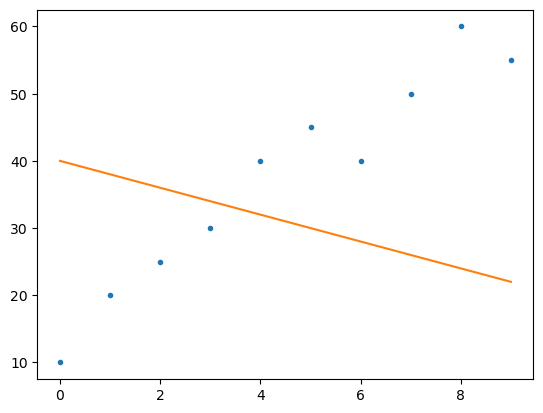

Loss: 475.5


In [18]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

m = -2  # -2 am Anfang, ändere mich 
b = 40  # 40 am Anfang, ändere mich

# Sample data
x = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9])
y = np.array([10, 20, 25, 30, 40, 45, 40, 50, 60, 55])
y_hat = x * m + b

plt.plot(x, y, '.')
plt.plot(x, y_hat, '-')
plt.show()

print("Loss:", np.sum((y - y_hat)**2)/len(x))

### Optimierung: Gradient Descent

Neuronale Netzwerke werden mit einer Menge Mathe-Magie optimiert.
- Wir haben eine Funktion die uns den Fehler angibt 
- Mittels Ableitungen können wir herausfinden in welche Richtung wir das Modell optimieren müssen um den Fehler zu minimieren

- Man kann es sich vorstellen als würde man auf einem Hügel stehen
- Mit dem Fuß ertastet man die steilste Richtung nach unten
- Und macht einen kleinen Schritt in dessen Richtung (`learning_rate` bestimmt die Schrittgröße)
    - Ist sie zu klein dauert es lange das Modell zu trainieren
    - Ist sie zu groß explodiert aber der Gradient! 
        - Wenn wir nach dem Schritt weiter vom Minimum weg sind als zuvor machen wir im Anschluss einen noch größeren Schritt
        - Das schaukelt sich sehr schnell richtung unendlich hoch

![](_img/04_gradient_descent.jpg)

In [19]:
# Schrittgröße
learning_rate = 0.0001
# Fehlerfunktion
criterion = nn.CrossEntropyLoss()
# Optimierungsalgorithmus 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Trainingspipeline

Im Training verbinden wir jetzt alles zusammen.

- Wir laden nacheinander Daten
- Lassen unser Modell eine Vorhersage treffen
- Berechnen die Verlustfunktion
- Berechnen in welche Richtung wir die Parameter anpassen müssen damit wir besser werden
- Und aktualisieren die Parameter

In [20]:
def train(model,train_loader,optimizer):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        # schiebe einagbe und lösung auf GPU
        images = images.to(device)
        labels = labels.to(device)

        # vorhersage treffen
        outputs = model(images)
        # berechne den Fehler
        loss = criterion(outputs, labels)
        # setze die Gradienten zurück (Ableitung)
        optimizer.zero_grad()
        # Berechne die Ableitung
        loss.backward()
        # Aktualisiere die Parameter
        optimizer.step()

        # Hier wird die Genauigkeit ermittelt
        # Finde heraus was die wahrscheinlichste Klasse war laut Modell
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # berechne wie viele im aktuellen Batch korrekt waren
        correct += (predicted == labels).sum().item()

    accuracy = (100 * correct / total)

    return loss.item(), accuracy

In [21]:
# Berechne Genauigkeit für Validierungssatz
def validate(model, val_loader, return_confusion_matrix = False):
  # schalte Gradientenberechnung aus
  with torch.no_grad():
      correct = 0
      total = 0
      if return_confusion_matrix:
         all_labels = []
         all_preds = []
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          if return_confusion_matrix:
             all_labels.extend(labels.cpu().numpy())
             all_preds.extend(predicted.cpu().numpy())
            
      accuracy = (100 * correct / total)

      if return_confusion_matrix:
         cm = confusion_matrix(all_labels, all_preds)
         return loss.item(), accuracy, cm
      
  return loss.item(),accuracy

### Alles zusammen

- Wir werden jetzt abwechseln trainieren und validieren
- Dabei das beste Modell auf den Validierungsdaten speichern
- Wir speichern zudem den Verlauf der Genauigkeit und des Fehlers für Training und Validierungsdaten

---
- Neue Variable: **Epoche**
- **Epoche** bezeichnet einen kompletten Durchlauf durch alle Trainingsdaten
- Erinnerung: wir schauen uns immer auf ein mal 64 von unseren knapp 40.000 Trainingsdaten an
- Die Epoche ist vorbei sobald alle 40.000 Trainingspunkte ein mal gesehen wurden

In [22]:
# Wie oft wir den kompletten Traingsdatensatz durchlaufen wollen
num_epochs = 25

# Listen zum Speichern der Genauigkeits und Fehlerverläufe 
T_loss= []
v_loss =[]
T_acc = []
v_acc = []

# zum Erkennen der besten Epoche: 
# setze den besten Validierungsfehler auf unendlich
best_val_loss = np.inf
best_model = model 

# Trainings-Schleife
for epoch in range(num_epochs):

  # Trainiere das Modell und lass Fehler und Genauigkeit ausgeben
  train_loss, train_acc = train(model, train_loader, optimizer)
  # Berechne Fehler und Genauigkeit auf Validierungsdaten
  val_loss, val_acc = validate(model, val_loader)

  # Schreibe aktuellen Stand
  print (f'Epoch [{epoch+1}/{num_epochs}], train Loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val Loss: {val_loss:.4f} , val acc: {val_acc:.4f}')
  
  # speichere die Werte ab
  T_loss.append(train_loss)
  v_loss.append(val_loss)
  T_acc.append(train_acc)
  v_acc.append(val_acc)

  # Check ob Modell sich verbessert hat
  if val_loss < best_val_loss:
    # wenn verbessert: speichere das beste Modell
    best_model = model

Epoch [1/25], train Loss: 0.3217, train acc: 83.0187, val Loss: 0.1698 , val acc: 91.4833
Epoch [2/25], train Loss: 0.1720, train acc: 92.5250, val Loss: 0.1363 , val acc: 93.7250
Epoch [3/25], train Loss: 0.1668, train acc: 94.3250, val Loss: 0.1068 , val acc: 94.9333
Epoch [4/25], train Loss: 0.1310, train acc: 95.3458, val Loss: 0.0845 , val acc: 95.4750
Epoch [5/25], train Loss: 0.0891, train acc: 96.1937, val Loss: 0.0833 , val acc: 95.9417
Epoch [6/25], train Loss: 0.1545, train acc: 96.7750, val Loss: 0.0946 , val acc: 96.4417
Epoch [7/25], train Loss: 0.0661, train acc: 97.2708, val Loss: 0.0779 , val acc: 96.8000
Epoch [8/25], train Loss: 0.0853, train acc: 97.6604, val Loss: 0.0510 , val acc: 97.1583
Epoch [9/25], train Loss: 0.0608, train acc: 98.0167, val Loss: 0.0449 , val acc: 97.0250
Epoch [10/25], train Loss: 0.0172, train acc: 98.2188, val Loss: 0.0402 , val acc: 97.4167
Epoch [11/25], train Loss: 0.0480, train acc: 98.5229, val Loss: 0.0431 , val acc: 97.5833
Epoch [1

### Plotten des Verlaufs

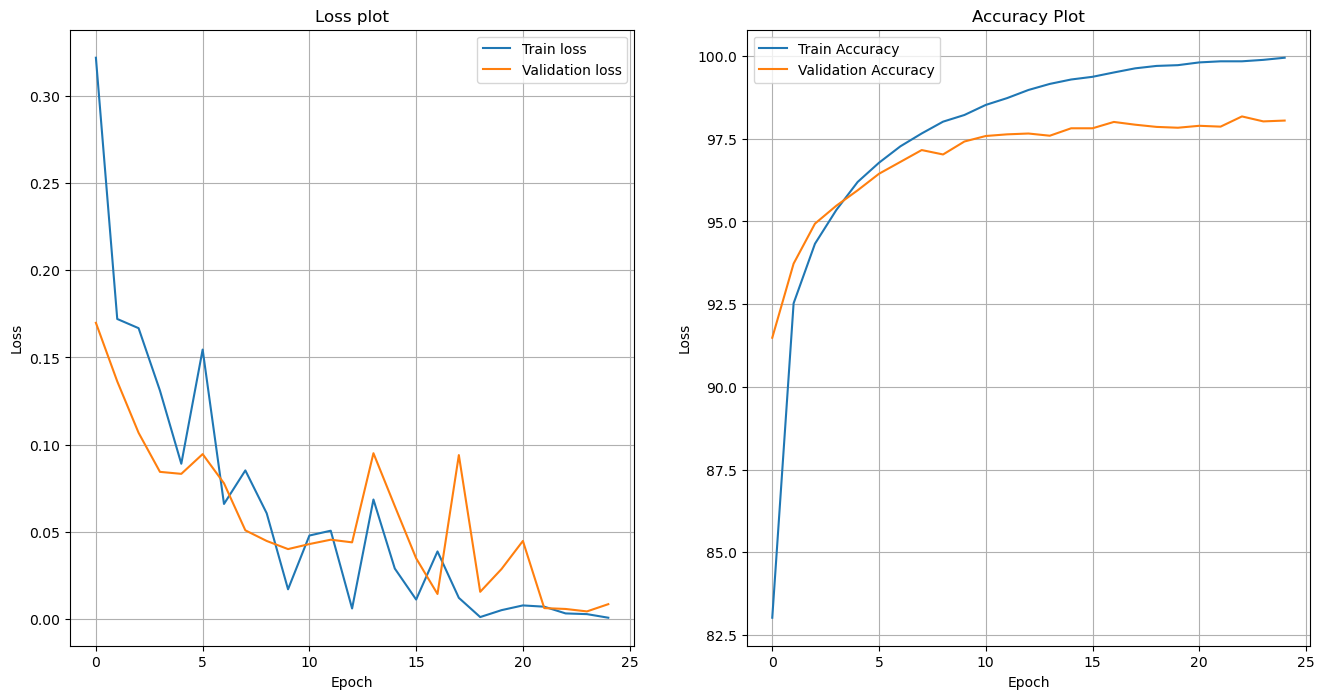

In [23]:
epochs = [i for i in range(len(T_loss))]

fig, ax = plt.subplots(ncols = 2, figsize=(16,8))

# Zeichne Verlust von Training und Validierung
ax[0].plot(epochs, T_loss, label='Train loss')
ax[0].plot(epochs, v_loss, label='Validation loss')
ax[0].set_title('Loss plot')

# Zeichne Genauigkeit auf zweitem Bild
ax[1].plot(epochs, T_acc, label='Train Accuracy')
ax[1].plot(epochs, v_acc, label='Validation Accuracy')
ax[1].set_title('Accuracy Plot')

# Beschriftung
for _ax in ax:
    _ax.set_xlabel('Epoch')
    _ax.set_ylabel('Loss')
    _ax.legend()
    _ax.grid()

# Plotten der Vorhersagen

In [24]:
def show_predictions(data_loader, model=best_model, num_samples=10):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    _, preds = torch.max(model(images.to(device)), 1)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy().squeeze().reshape(28,28), cmap='gray')
        ax.set_title(f"label: {labels[i]}\npred: {preds[i].cpu()}")
        ax.axis('off')

    plt.show()

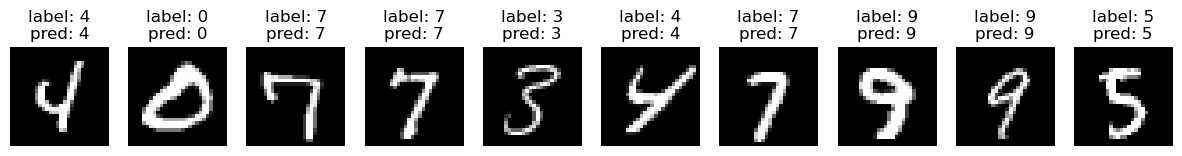

In [25]:
show_predictions(train_loader)

Zum Schluss dürften wir jetzt auch den Testdatensatz evaluieren :-) 

In [26]:
loss, acc, confusion_matrix = validate(best_model, test_loader, return_confusion_matrix = True)

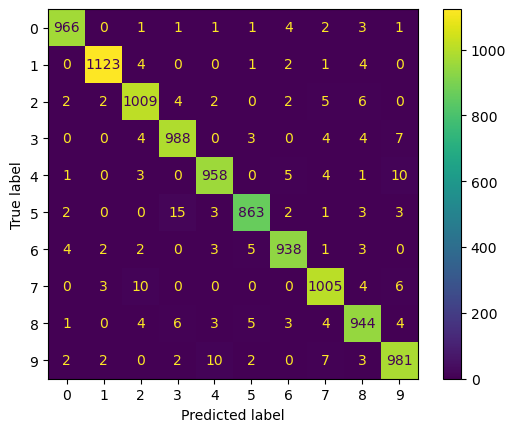

In [28]:
ConfusionMatrixDisplay(confusion_matrix).plot()

# Glückwunsch! 

Du hast gerade dein erstes Neuronales Netzwerk trainiert und es ist nahezu perfekt im erkennen handgeschriebener Ziffern! 

# Linksammlung

Klick auf einen der Links um in die jeweiligen Notebooks zu wechseln

1. [Basics Notebook](https://colab.research.google.com/github/aleks-krasowski/femtec_ml_workshop/blob/main/notebooks/01_basics.ipynb)
2. [EDA Notebook](https://colab.research.google.com/github/aleks-krasowski/femtec_ml_workshop/blob/main/notebooks/02_exploratory_data_analysis.ipynb)
3. [ML Notebook](https://colab.research.google.com/github/aleks-krasowski/femtec_ml_workshop/blob/main/notebooks/03_conventional_ml.ipynb)
4. [DL Notebook](https://colab.research.google.com/github/aleks-krasowski/femtec_ml_workshop/blob/main/notebooks/04_deep_learning.ipynb)